# SWAG-P Simulation with Gap Plasmon Explorer

#### GP Explorer is a handly tools allowing to manipulate GP geometries and visualize its reflectance under differents configurations. Then, GP influence on reflectance from red-shift to Fano profils can be studying without programming skills.

To begin, remember that a GP<sup><a href="#note1">[1]</a></sup> -a guided electromagnetic wave into dielectric-, must be undertand as a mode of the nano cavity -the so called "gap"- between two close metallic regions.





<p id="note1"><b>[1]</b> A solution of Maxwell's equations without source.</p>

In the next cell, we will set up the environment by importing necessary modules and defining paths to required data files ensuring that all dependencies are correctly loaded and accessible for subsequent computations.

In [1]:
# %% Cellule 1 – Initialisation
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Ajout du chemin vers le dossier des modules
module_path = os.path.abspath(os.path.join('/home/chardon-grossard/Bureau/SWAG-P/Gap_Plasmon_2D/Workspace/', 'modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Définir le chemin vers le fichier JSON combiné pour les données ExpData et BB
json_path = os.path.abspath(os.path.join('/home/chardon-grossard/Bureau/SWAG-P/Gap_Plasmon_2D/Workspace/', 'data', 'combined_materials.json'))

In [2]:
# %% Cellule 2 – Configuration de la géométrie
from geometry_settings import create_geometry_widget, geometry_config, wave

# Créer et afficher le widget de géométrie
geom_widget = create_geometry_widget()
display(geom_widget)


GEOMETRY_CONFIG a été mis à jour dans l'espace global (__main__).
GEOMETRY_CONFIG a été mis à jour dans l'espace global (__main__).


In [3]:
# %% Cellule 3– Sélection interactive des matériaux
from material_selector import create_material_selector

material_selector_widget = create_material_selector(json_path)
display(material_selector_widget)


MATERIALS_CONFIG a été défini dans l'espace global __main__


MATERIALS_CONFIG a été défini dans l'espace global __main__


In [8]:
# %% Cellule 4– Construction de la configuration matériaux
lambda_test = 800  # Longueur d'onde en nm

import __main__
if not hasattr(__main__, "MATERIALS_CONFIG"):
    print("Veuillez valider la configuration matériaux dans la cellule précédente.")
else:
    from Material_Configuration import build_material_configuration_dynamic
    materials_perm = build_material_configuration_dynamic(__main__.MATERIALS_CONFIG, lambda_test, json_path)
    print("Configuration matériaux obtenue:")
    for key, value in materials_perm.items():
        print(f"{key} : {value}")


Configuration matériaux obtenue:
perm_env : (1+0j)
perm_dielec : (1.7635840000000003+0j)
perm_sub : (2.282506834619155+0j)
perm_reso : (-40.06029991951217-0.2413306314051874j)
perm_metalliclayer : (-27.172511539078222+2.826754475180965j)
perm_accroche : (-3.074309432706581+14.002769236764227j)
perm_func : 2.0
perm_mol : 1.0


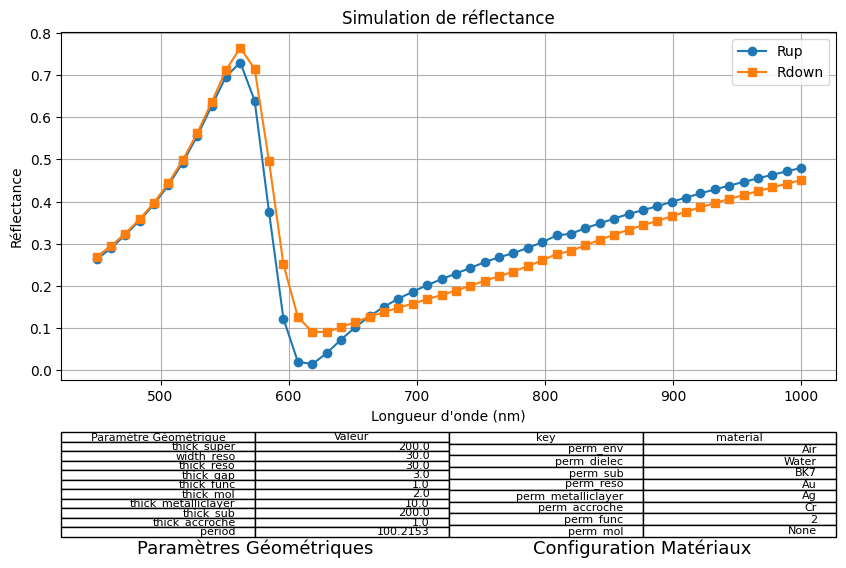

Simulation terminée. Réflectance finale pour lambda = 1000.0 : 0.47991618174238676 0.45095308286424635


In [9]:
# %% Cellule 5 – Simulation de la réflectance
from simulate_and_plot import run_simulation

lambda_range = np.linspace(450, 1000, 50)  # en nm
n_mod = 50

import __main__
if not hasattr(__main__, "MATERIALS_CONFIG"):
    print("Veuillez valider la configuration matériaux dans la cellule 3.")
else:
    Rup_values, Rdown_values = run_simulation(lambda_range, n_mod, geometry_config, wave, __main__.MATERIALS_CONFIG, json_path)
    print("Simulation terminée. Réflectance finale pour lambda =", lambda_range[-1], ":", Rup_values[-1], Rdown_values[-1])
